In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import operator
import os
import warnings
from os import listdir
from os.path import isfile, join


from PIL import Image
from pyshtools.legendre import legendre
from scipy.optimize import minimize

from lib3 import *
from parameters import *

warnings.filterwarnings("ignore")
import mpmath as mp
from enum import Enum
from time import sleep
from numba import jit, prange

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large'}
plt.rcParams.update(params)


class Color(Enum):
    MINIMIZEPOSITION = 1
    FINDNEIGHBORHOOD = 2
    EVALUATE_DF_AT_POSITION = 3
    FINDBESTFORKRANGE = 4
    OPTIMIZE_SPECTRUM = 5
    CREATE_GAUSSIAN_BACKGROUND = 6


def get_chopped_range(lmax, n=20, lmin=1):
    llist = sorted(list( { int(np.round(x,0)) for x in np.linspace(lmin,lmax, n) }))
    return llist


@jit(parallel=True)
def eval_my_gegenbauer(aa, bb, cosksi):
    A = np.zeros(cosksi.shape)
    for i in prange(len(cosksi)):
        # A[i] = sp.eval_gegenbauer(aa, bb, cosksi[i])
        A[i] = mp.gegenbauer(aa, bb, cosksi[i])
    return A.astype(float)

def sinxx(xx):
    y = np.zeros(xx.shape)
    for i, x in enumerate(xx):
        if x == 0:
            y[i] = 1.0
        else:
            y[i] = np.sin(x) / x
    return y

def optimzeSpectraC(df, x0, opt=False, kkk=None):
    def erroC(x, df):
        k = df.k - 2
        dk = x[0] * k + x[1] * k ** 2 + x[2] * k ** 3
        dl = x[3] * df.l + x[4] * df.l ** 2
        dm = x[5] * np.abs(df.m) + x[6] * df.m ** 2
        df["population"] = x[7] + dk + dl + dm
        dfG = pd.DataFrame(df.groupby(['k', "l"])["CL", "population"].apply(lambda x: x.astype(float).mean()),
                           columns=["CL", "population"])
        dfG["CL"] /= dfG["CL"].max()
        err = np.sum((dfG.population - dfG.CL) ** 2)
        print(err)
        return err

    if opt:
        if kkk:
            df = df[(df.k == kkk[0]) * (df.l == kkk[1])]
        xout = minimize(erroC, x0, args=(df), method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        print("errC", xout.fun, xout.x)
        return xout.x, df
    else:
        x = x0
    ##########################################################
    if kkk:
        df = df[(df.k == kkk[0]) * (df.l == kkk[1])]
        plt.plot(df.m, df.coeff)
        plt.show()
    k = df.k - 2
    dk = x[0] * k + x[1] * k ** 2 + x[2] * k ** 3
    dl = x[3] * df.l + x[4] * df.l ** 2
    dm = x[5] * np.abs(df.m) + x[6] * df.m ** 2
    df["population"] = x[7] + dk + dl + dm
    dfG = pd.DataFrame(df.groupby(['k', "l"])["CL", "population"].apply(lambda x: x.astype(float).mean()),
                       columns=["CL", "population"])
    dfG["CL"] /= dfG["CL"].max()
    dfG["difference"] = (dfG.CL - dfG.population) / dfG.population
    dfG["zero"] = 0.0
    dfG["one"] = 1.0
    ##########################################################
    ax = dfG.CL.plot(legend=False)
    # dfG.population.plot( ax=ax)

    plt.xlabel('Hyperspherical Harmonic k')
    plt.title('Power Spectrum C')
    plt.ylabel("Hyperspherical Harmonic Mode Population")
    # plt.ylim(0, 2)
    plt.show()

def get_legendre(a):
    ii = a[0]
    lrange = a[1]
    chunck = a[2]
    lmax = np.max(lrange)
    pp = np.zeros([len(chunck), len(lrange), lmax + 1])
    for i, x in enumerate(chunck):
        pp[i, :, :] = legendre(lmax, x, csphase=-1)[lrange]
    return ii, pp

def get_P(lrange, costheta):
    lmax = np.max(lrange)
    pp = np.zeros([0, len(lrange), lmax + 1])
    lencos = len(costheta)
    number_of_workers = 10
    P = {}
    mychunks = chunks(costheta, lencos // number_of_workers, lrange)
    with ProcessPoolExecutor(max_workers=number_of_workers) as executor:
        responses = executor.map(get_legendre, mychunks)
    for response in responses:
        i = response[0]
        P[i] = response[1]
    for key in np.sort(list(P.keys())):
        pp = np.concatenate([pp, P[key]], axis=0)
    return pp

def functionG(a):
    l = a[0][0] - 1
    k = a[0][1] + l
    cosksi = a[1]
    A = np.array([float(mp.gegenbauer(1 + l, k - l, x)) for x in cosksi])
    print("ended {}_{}".format(k, l))
    return (a[0], A)

def get_gegenbauerAsyn(cosksi,extra_G_keys):
    number_of_workers = 10
    multiindex = pd.MultiIndex.from_tuples(extra_G_keys, names=('k', 'l'))
    columns = list(np.arange(len(cosksi)))
    if len(extra_G_keys) == 0:
        return
    extraG = pd.DataFrame(data=np.zeros([len(multiindex), len(columns)]), index=multiindex, columns=columns)
    extra_G_keys = ((x,cosksi) for x in extra_G_keys)
    with ProcessPoolExecutor(max_workers=number_of_workers) as executor:
        responses = executor.map(functionG, extra_G_keys )
    for response in responses:
        extraG.loc[response[0], :] = response[1]
    return extraG

def plot_aitoff(fcolors, cmap=cm.RdBu_r):
    hp.mollview(fcolors.squeeze(), cmap=cmap)
    hp.graticule()
    plt.show()

def plot_aitoff_df(l, m, df, cmap=cm.RdBu_r):
    def plot_orth(fcolors):
        sigma = np.std(fcolors)
        hp.orthview(fcolors, min=-2 * sigma, max=2 * sigma, title='Raw WMAP data', unit=r'$\Delta$T (mK)')
        plt.show()

    def get_LM(l, m, df):
        if m >= 0:
            ind = (l + 1) * (l + 2) - l + m
            return df[0, ind, :]
        if m < 0:
            ind = (l + 1) * (l + 2) - l + m
            return df[1, ind, :]

    fcolors = get_LM(l, m, df)
    plot_aitoff(fcolors, cmap=cmap)
    plot_orth(fcolors)

def B_l(beam_arcmin, ls1):
    theta_fwhm = ((beam_arcmin / 60.0) / 180) * math.pi
    theta_s = theta_fwhm / (math.sqrt(8 * math.log(2)))
    return np.exp(-2 * (ls1 + 0.5) ** 2 * (math.sin(theta_s / 2.0)) ** 2)

def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

def chunks(lst, n, args=None):
    """Yield successive n-sized chunks from lst."""
    maxn = len(lst)
    for i in range(0, maxn, n):
        nextstep = i + n
        if nextstep > maxn:
            nextstep = maxn
        if args is not None:
            yield (i, args, lst[i:nextstep])
        else:
            yield (i, lst[i:nextstep])

def chg2ang(alpha):
    residue = alpha % (2 * np.pi)
    return int(residue * 180 / np.pi)

def newerr(x, SMICA_LR, newmap):
    newnewmap = SMICA_LR.squeeze() - x[1] * newmap.squeeze() + x[0]
    err = np.std(newnewmap)
    return err


class HYPER:
    def __init__(self, nside3D, sigma_smica, planck_IQU_SMICA, karray, mypath,
                 lambda_k=0.0, lambda_l=0.0, lambda_m=0.0, bandwidth=256,
                 loadpriorG=False, savePG=False, longG=False):
        self.G = pd.DataFrame()
        self.loadpriorG=loadpriorG
        self.savePG=savePG
        self.extra_G_keys={}
        self.extra_P_keys = {}
        self.longG = longG
        self.nside3D = nside3D
        self.bandwidth = bandwidth
        self.df = np.zeros([1, 1])
        self.results = {}
        self.sigma_smica = sigma_smica
        self.xx, self.yy, self.zz = hp.pix2vec(nside=nside3D, ipix=np.arange(hp.nside2npix(nside3D)))
        self.k1 = min(karray)
        self.kmax = max(karray)
        self.karray = karray
        self.mypath = mypath
        self.G_filename = os.path.join(self.mypath, "G_{}_{}_{}_{}.npy".format(self.nside3D,
                                                                                  chg2ang(lambda_k),
                                                                                  chg2ang(lambda_l),
                                                                                  chg2ang(lambda_m)))
        self.P_filename = os.path.join(self.mypath, "P_{}_{}_{}_{}_".format(self.nside3D,
                                                                               chg2ang(lambda_k),
                                                                               chg2ang(lambda_l),
                                                                               chg2ang(lambda_m)))
        if loadpriorG:
            if os.path.exists(self.G_filename):
                self.G = pd.read_pickle(self.G_filename)
        self.sinksi = np.zeros([1, 1])
        self.cosksi = np.zeros([1, 1])
        self.phi = np.zeros([1, 1])
        self.x = np.zeros([1, 1])
        self.y = np.zeros([1, 1])
        self.z = np.zeros([1, 1])
        self.costheta = np.zeros([1,1])
        self.lambda_k, self.lambda_l, self.lambda_m = (lambda_k, lambda_l, lambda_m)
        self.SMICA = self.normalizeFColors(planck_IQU_SMICA, sigma_smica)
        self.SMICA_LR = self.SMICA
        self.newmap = np.zeros(self.SMICA.shape)
        self.change_SMICA_resolution(nside3D, doit=True, bandwidth=bandwidth)
        self.change_HSH_center(self.lambda_k, self.lambda_l, self.lambda_m, self.karray,
                               self.nside3D, loadpriorG=loadpriorG, doit=True, savePG=savePG)

    def change_SMICA_resolution(self, nside3D, doit=False, bandwidth=256):
        if (self.nside3D == nside3D) and not doit:
            return
        filename = "./img1/SMICA_{}_{}.png".format(nside3D, bandwidth)
        title = "SMICA_nside3D={}_{}".format(nside3D, bandwidth)
        self.SMICA_LR = self.change_resolution(self.SMICA, nside3D=nside3D, bandwidth=bandwidth,
                                               title=title, filename=filename,
                                               plotme=True, save=True)
        mu, sigma = norm.fit(self.SMICA_LR)
        self.SMICA_LR = (self.SMICA_LR - mu) / sigma * self.sigma_smica

    def factorMP(self, k, l, m):
        m = np.abs(m)
        a = (-1) ** m * np.sqrt((2 * l + 1) / (2 * np.pi) * mp.factorial(l - m) / mp.factorial(l + m))
        b = (-1) ** k * np.sqrt(
            2 * (k + 1) / np.pi * mp.factorial(k - l) / mp.factorial(k + l + 1) * 2 ** (2 * l) * mp.factorial(l) ** 2)
        c = float(a * b)
        return c

    def normalizeFColors(self, fcolors, sigma_smica):
        (mu, sigma) = norm.fit(fcolors)
        if sigma == 0.0:
            return fcolors
        return sigma_smica / sigma * (fcolors - mu)

    def getSpectralFiles(self, mypath):
        return [join(mypath, f) for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]

    def creategiff(self, kmax, nside3D, mypath="./img1", prefix="aitoff_", filename="CMB"):
        giffiles = self.getSpectralFiles(mypath)
        giffiles = [x for x in giffiles if prefix in x]
        images = []
        for ff in giffiles:
            with Image.open(ff).convert("RGB") as img:
                images.append(img)
        fname = os.path.join(mypath, filename) + '_{}_{}.gif'.format(kmax, nside3D)
        images[0].save(fname, save_all=True, append_images=images[1:], optimize=False, duration=1000, loop=0)

    def creategiffMem(self, x):
        # err, prime, results, fig
        images = [y[3] for y in x]
        titles = [y[1] for y in x]
        errs = [y[0] for y in x]
        for i, xx in enumerate(images):
            (lk, ll, lm) = [x for x in titles[i]]
            err = errs[i]
            filename = "./img1/aitoff_{}_{}_{}_{}.png".format(kmax, chg2ang(lk), chg2ang(ll), chg2ang(lm))
            # draw the canvas, cache the render
            xx.seek(0)
            im = Image.open(xx)
            im.save(filename)

    def change_resolution(self, fcolors, nside3D=1024, filename=None,
                          title=None, save=False, plotme=None, bandwidth=256):
        # noinspection PyUnresolvedReferences
        SMICA_alms = hp.map2alm(fcolors, lmax=bandwidth)
        fcolors = hp.alm2map(SMICA_alms, nside=nside3D)
        (mu, sigma) = norm.fit(fcolors)
        if sigma != 0.0:
            fcolors = (fcolors - mu) / sigma * self.sigma_smica
        fcolors = np.expand_dims(fcolors, axis=1)
        self.plot_aitoff(fcolors.squeeze(), kk=0, ll=0, mm=0, err=0, filename=filename, title=title, save=save,
                         plotme=plotme)
        return fcolors

    def plotHistogram(self, fcolors, nside3D, kmax, plotme=False):
        (mu, sigma) = norm.fit(fcolors)
        n, bins, patch = plt.hist(fcolors, 600, density=1, facecolor="r", alpha=0.25)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y)
        plt.xlim(mu - 4 * sigma, mu + 4 * sigma)
        plt.xlabel("Temperature/K")
        plt.ylabel("Frequency")
        plt.title(r"Histogram {}_{} HU Modeling of Planck SMICA Map ".format(kmax, nside3D), y=1.08)
        plt.savefig("./img1/Histogram_{}_{}.png".format(kmax, nside3D), dpi=300)
        if plotme:
            plt.show()

    def plot_aitoff(self, fcolors, kk, ll, mm, err, filename=None, title=None, plotme=False, save=False, nosigma=True):
        # noinspection PyUnresolvedReferences
        plt.clf()
        if title is None:
            title = "{}_{}_{}_{}".format(kmax, chg2ang(kk), chg2ang(ll), chg2ang(mm))

        f = plt.figure()
        if nosigma:
            hp.mollview(fcolors.squeeze(), title=title, min=-2 * self.sigma_smica,
                        max=2 * self.sigma_smica, unit="K", cmap=cm.RdBu_r)
        else:
            mu, sigma = norm.fit(fcolors.squeeze())
            hp.mollview(fcolors.squeeze(), title=title, min=mu - 2 * sigma,
                        max=mu + 2 * sigma, unit="K", cmap=cm.RdBu_r)
        hp.graticule()
        if save:
            plt.savefig(filename, format='png')
        if plotme:
            plt.show()
        f.clear()
        plt.close(f)

    def pickledict(self, test_dict, filename='./errarray.pickle'):
        import pickle
        with open(filename, 'wb') as handle:
            pickle.dump(test_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def unpickledict(self, filename='./errarray.pickle'):
        import pickle
        with open(filename, 'rb') as handle:
            text_dict = pickle.load(handle)
        return text_dict

    def plot_Single_CL_From_Image(self, fcolors, nside,ymin=1E-6, xmax=300, log=False):
        dl_SMICA, ell = self.get_dl(fcolors, nside)
        dl_SMICA = dl_SMICA / np.max(dl_SMICA)
        fig = plt.figure(figsize=[12, 12])
        ax = fig.add_subplot(111)
        ax.plot(ell, dl_SMICA)
        ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")
        ax.set_ylabel('$\ell$')
        ax.set_title("Angular Power Spectra")
        ax.legend(loc="upper right")
        if log:
            ax.set_yscale("log")
        ax.set_xlim(1, xmax)
        ax.set_ylim(ymin, 1)
        ax.grid()
        plt.show()
        return cl_SMICA, dl_SMICA, ell

    def plot_CL_From_Image(self, fcolors, nside, planck_theory_cl, xmax=3000, ymax=1.0):
        dl_SMICA, ell = self.get_dl(fcolors, nside)
        dl_SMICA = dl_SMICA / np.max(dl_SMICA)
        planck_theory_cl[:, 1] = planck_theory_cl[:, 1] / np.max(planck_theory_cl[10:3000, 1])
        fig = plt.figure(figsize=[12, 12])
        ax = fig.add_subplot(111)
        ax.plot(planck_theory_cl[:, 0], planck_theory_cl[:, 1])
        ax1 = plt.twinx(ax)
        ax1.plot(ell, dl_SMICA)
        ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")
        ax.set_ylabel('$\ell$')
        ax.set_title("Angular Power Spectra")
        ax.legend(loc="upper right")
        # ax1.set_yscale("log")
        ax.set_xlim(10, xmax)
        ax1.set_xlim(10, xmax)
        # ax1.set_ylim(1E-4, ymax)
        ax1.grid()
        plt.show()
        return cl_SMICA, dl_SMICA, ell

    def get_dl(self, fcolors, nside):
        cl_SMICA = hp.anafast(fcolors)
        ell = np.arange(len(cl_SMICA))
        pl = hp.sphtfunc.pixwin(nside=nside)
        # Deconvolve the beam and the pixel window function
        dl_SMICA = cl_SMICA / (B_l(10.0, ell) ** 2 * pl ** 2)
        dl_SMICA = (ell * (ell + 1) * dl_SMICA / (2 * math.pi))
        return dl_SMICA, ell

    def plot_ONLY_CL_From_Image(self, fcolors, nside, smica, nsidesmica, xmax=30):
        dl_SMICA_HU, ell = self.get_dl(fcolors.squeeze(), nside=nside)
        dl_SMICA, ell1 = self.get_dl(smica.squeeze(), nside=nsidesmica)
        dl_SMICA_HU /= np.max(dl_SMICA_HU[0:len(ell) // 2])
        dl_SMICA /= np.max(dl_SMICA[0:len(ell1) // 2])
        fig = plt.figure(figsize=[12, 12])
        ax = fig.add_subplot(111)
        ax.set_xlabel("$ell(ell+1)C_ell/2\pi \, \,(\mu K^2)$")
        line, = ax.plot(ell1, dl_SMICA)
        line.set_label('SMICA')
        ax1 = plt.twinx(ax)
        line1, = ax1.plot(ell, dl_SMICA_HU)
        line1.set_label('HU')
        ax1.set_ylabel('$\ell$')
        ax1.set_title("Angular Power Spectra {}_{}".format(self.kmax, self.nside3D))
        ax1.legend(loc="upper right")
        ax1.set_xlim(1, xmax)
        plt.ylim(1E-10, 1)
        ax1.grid()
        plt.savefig("./img1/AngularPowerSpectra_{}_{}.png".format(kmax, nside3D), dpi=300)
        plt.show()
        return dl_SMICA, dl_SMICA_HU, ell

    def plotSH(self, l, m, ll, lm, pp):
        fcolors = self.spherharmm(l, m, self.phi, pp)
        hp.mollview(fcolors.squeeze(), title="{}_{}_{}_{}".format(l, m, chg2ang(ll), chg2ang(lm)), cmap=cm.RdBu_r)
        hp.graticule()
        plt.show()
        return fcolors

    def plotNewMap(self, newmap, err, filename=None, title=None, plotme=False, save=False, nosigma=True):
        err0 = np.round(err, 3)
        if filename is None:
            filename = "./img1/aitoff_{}_{}_{}__{}_{}_{}.png".format(self.kmax, self.nside3D, err0,
                                                                     chg2ang(self.lambda_k),
                                                                     chg2ang(self.lambda_l),
                                                                     chg2ang(self.lambda_m))
        if title is None:
            title = "{}_{}_{}__{}_{}_{}".format(self.kmax, self.nside3D, err0, chg2ang(self.lambda_k),
                                                chg2ang(self.lambda_l),
                                                chg2ang(self.lambda_m))
        self.plot_aitoff(newmap, self.lambda_k, self.lambda_l,
                         self.lambda_m, err0, title=title, filename=filename, plotme=plotme, save=save, nosigma=nosigma)

    def calcStuff(self, alpha):
        err = 0.0
        results = 0.0
        prime = alpha[0]
        kmax = alpha[1]
        lk = prime[0]
        ll = prime[1]
        lm = prime[2]
        start_time = time()
        try:
            results, fcolors, ls, err = self.project4D3d_0(kmax)
        except Exception as exception_object:
            print('Error with getting map for: {0}_{0}_{0}'.format(lk, ll, lm))
        stop_time = time()
        print(alpha, err)
        return [start_time, stop_time, err, prime, results]

    def mindict(self, test_dict):
        # Using min() + list comprehension + values()
        # Finding min value keys in dictionary
        temp = min(test_dict.values())
        res = [key for key in test_dict if test_dict[key] == temp]
        return res[0], test_dict[res[0]]

    def calcError(self, x, karray):
        t1 = datetime.now()
        self.change_HSH_center(x[0], x[1], x[2], karray, nside3D, loadpriorG=False, doit=True, savePG=False)
        _, _, err = self.project4D3d_0(karray)
        print(x, err, (datetime.now() - t1).microseconds)
        return err

    def calcErrorDF(self, x):
        err = np.sum((np.dot(x.T, self.df[:, 4:]) - self.SMICA_LR.squeeze()) ** 2) * 1E6
        return err

    def cleanup(self, mypath, prefix):
        filelist = [join(mypath, f) for f in sorted(listdir(mypath)) if
                    isfile(join(mypath, f)) and f.startswith(prefix)]
        for f in filelist:
            if os.path.exists(f):
                os.remove(f)
            else:
                print("The file does not exist")

    def get_all_gegenbauer(self):
        if not self.loadpriorG:
            self.G = pd.DataFrame()
        G=[]
        for k in np.arange(2,np.max(self.karray)+1):
                for l in np.arange(1,k):
                    if (1+l,k-l) not in self.G.index:
                        G.append( (1+l,k-l) )
        if len(G)!=0:
            self.G = get_gegenbauerAsyn(self.cosksi, G)
        if self.savePG:
            self.G.to_pickle(self.G_filename)

    def change_HSH_center(self, lk, ll, lm, karray, nside, doit=False, loadpriorG=False, savePG=False):
        kmax = max(karray)
        if nside != self.nside3D:
            self.xx, self.yy, self.zz = hp.pix2vec(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
            self.nside3D = nside
        if not doit:
            array_number_match = len(self.karray) == len(karray)
            if array_number_match:
                array_match = np.sum(self.karray == karray) != 0
            else:
                array_match = False
            if (self.lambda_k, self.lambda_l, self.lambda_m, self.kmax) == (lk, ll, lm, kmax) \
                    and array_number_match and array_match:
                return
        self.loadpriorG = loadpriorG
        if not loadpriorG:
            self.G = pd.DataFrame()
        self.get_df_size(karray, aggregLevel="M")
        self.lambda_k = lk
        self.lambda_l = ll
        self.lambda_m = lm
        self.G_filename = os.path.join(self.mypath, "G_{}_{}_{}_{}.npy".format(self.nside3D,
                                                                                  chg2ang(lk),
                                                                                  chg2ang(ll),
                                                                                  chg2ang(lm)))
        self.z = self.zz + lk
        self.y = self.yy + ll
        self.x = self.xx + lm
        self.cosksi = np.cos(self.z)
        self.sinksi = np.sin(self.z)
        self.costheta = np.cos(self.y)
        self.phi = self.x
        self.get_all_gegenbauer()
        kjump = 20
        ibeginning=0
        for i in np.arange(kjump, self.kmax, kjump):
            newPfile = self.P_filename + "{}.npy".format(i)
            if not os.path.exists(newPfile):
                pp = get_legendre((0,np.arange(ibeginning,i), self.costheta))[1].squeeze()
                np.save(newPfile,pp)
                ibeginning=i


    def createGaussianBackground(self, x0, nside, delta, karray):
        xx, yy, zz = hp.pix2vec(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
        x, y, z = tuple(map(operator.add, (xx, yy, zz), x0))
        theta = y
        phi = x
        ############################################################
        ############################################################
        # random amplitudes
        wavefunction = np.zeros(xx.shape)
        costheta = np.cos(theta)
        t1 = datetime.now()
        pp = self.get_P(karray, costheta)
        print((datetime.now() - t1).seconds)
        for ii, l in enumerate(karray):
            mu = 1 / np.sqrt(2 * l + 1)
            sigma = mu / np.sqrt(2 * l + 1)
            amp = np.abs(np.random.normal(mu, sigma, [1, 2 * l + 1]))
            mlist = list(set([int(np.round(kk)) for kk in np.linspace(-l, l, 20)]))
            for m in mlist:
                if m > 0:
                    wavefunction += amp[0, l + m] * self.spherharmm(ii, l, m, phi, pp) * np.sin(l * delta)
                if m == 0:
                    wavefunction += amp[0, l + m] * self.spherharmm(ii, l, m, phi, pp)
                if m < 0:
                    wavefunction += amp[0, l + m] * self.spherharmm(ii, l, m, phi, pp) * np.cos(l * delta)
        ############################################################
        return wavefunction

    def project4D3d(self, karray):
        self.kmax = np.max(karray)
        self.calc_hyperharmnano2(karray)
        SMICA = self.SMICA_LR
        C = np.dot(self.df[:, 4:], SMICA)
        B = np.dot(self.df[:, 4:], self.df[:, 4:].T)
        results = np.linalg.solve(B, C)
        self.newmap = np.dot(results.T, self.df[:, 4:])
        sigma = np.std(self.newmap)
        self.newmap = self.newmap / sigma * self.sigma_smica
        err = (1.0 - np.correlate(self.newmap.squeeze(), self.SMICA_LR.squeeze()) * 1e4)[0]
        return results, self.newmap, err

    def eval_my_gegenbauer(self, k, l):
        A = np.zeros(self.cosksi.shape)
        for i, x in enumerate(self.cosksi):
            A[i] = mp.gegenbauer(1 + l, k - l, x)
            # A[i] = sp.eval_gegenbauer(1 + l, k - l, x)
        return A

    def get_gegenbauer(self):
        multiindex = pd.MultiIndex.from_tuples(list(self.extra_G_keys()), names=('k', 'l'))
        columns = list(np.arange(len(self.xx)))
        extra_G_keys = [x for x in self.extra_G_keys()]
        if len(extra_G_keys) == 0:
            return
        data = np.zeros([len(multiindex), len(columns)])
        extraG = pd.DataFrame(data=data, index=multiindex, columns=columns, dtype=float)
        for aa, bb in self.extra_G_keys():
            l = aa - 1
            k = bb + l
            a = eval_my_gegenbauer(aa, bb, self.cosksi)
            if len(np.argwhere(np.isnan(a))) == 0:
                extraG.loc[(aa, bb), :] = a
            else:
                print("error", aa, bb, k, l)
        self.G = pd.concat([self.G, extraG], axis=0)

    def get_P(self, l, costheta):
        pp = np.zeros([0, kmax + 1, kmax + 1])
        lencos = len(costheta)
        number_of_workers = 10
        mychunks = chunks(costheta, lencos // number_of_workers, l)
        P = {}
        with ProcessPoolExecutor(max_workers=number_of_workers) as executor:
            responses = executor.map(get_legendre, mychunks)
        for response in responses:
            i = response[0]
            P[i] = response[1]
        for key in np.sort(list(P.keys())):
            pp = np.concatenate([pp, P[key]], axis=0)
        return pp

    # def calc_hyperharmnano2(self, karray):
    #     kmax = np.max(karray)
    #     files = sorted( [x for x in self.getSpectralFiles(self.mypath) if "/PG_data/P_" in x] )
    #     karray = [eval(x.replace(self.mypath,"").replace(".npy","").split("_")[-1:][0]) for x in files]
    #     filesMap = {x:y for (x,y) in zip(karray, files)}
    #     jj = 0
    #     G = {}
    #     listofk = [x for x in sorted(list(filesMap.keys())) if x <=kmax]
    #     for k in listofk:
    #         pp = np.load(filesMap[k])
    #         # if self.longG:
    #         #     b = np.zeros(self.xx.shape)
    #         llist = [np.count_nonzero(x, axis=0) for x in pp[0,:,:].squeeze()]
    #         llist = [x-1 for x in llist if x<k+1]
    #         for ii, l in enumerate(llist):
    #             if self.longG:
    #                 b = np.zeros(self.xx.shape)
    #             if (1+l,k-l) not in self.G.index:
    #                 G[1+l,k-l]=1.0
    #                 continue
    #             a = self.sinksi ** l * self.G.loc[(1 + l, k - l), :].values
    #             a1 = (-1) ** k * np.sqrt(2 * (k + 1) / np.pi * mp.factorial(k - l)
    #                                      * mp.power(2,2 * l) * mp.factorial(l) ** 2 / mp.factorial( k + l + 1))
    #             a1 = float(a1)
    #             for m in np.arange(-l,l+1):
    #                 if not self.longG:
    #                     b = a * a1 * self.spherharmm(ii, l, m, self.phi, pp)
    #                     c = b.std()
    #                     if c != 0:
    #                         self.df[jj, 0] = k
    #                         self.df[jj, 1] = l
    #                         self.df[jj, 2] = m
    #                         self.df[jj, 3] = c
    #                         self.df[jj, 4::] = b / c
    #                         jj += 1
    #                     else:
    #                         print(k, l, m)
    #                 else:
    #                     b += a * a1 * self.spherharmm(ii, l, m, self.phi, pp)
    #                     print(k,l,m)
    #                     if self.longG:
    #                         c = b.std()
    #                         if c != 0:
    #                             self.df[jj, 0] = k
    #                             self.df[jj, 1] = 0
    #                             self.df[jj, 2] = 0
    #                             self.df[jj, 3] = c
    #                             self.df[jj, 4::] = b / c
    #                             jj += 1
    #                         else:
    #                             print(k, "wavefunction failed")
    #     if len(G.keys())!=0:
    #         self.extra_G_keys=G.keys
    #         self.get_gegenbauer()
    #         print("DO IT AGAIN")
    #     print(jj)

    def calc_hyperharmnano2(self, karray):
        kmax = np.max(karray)
        npoints = len(self.xx)
        files = sorted( [x for x in self.getSpectralFiles(self.mypath) if "/PG_data/P_" in x] )
        karray0 = [eval(x.replace(self.mypath,"").replace(".npy","").split("_")[-1:][0]) for x in files]
        filesMap = {x:y for (x,y) in zip(karray0, files)}
        G = {}
        listofk = [x for x in sorted(list(filesMap.keys())) if x <=kmax]
        calcpp = len(listofk)==0 or kmax < 50
        if calcpp:
            listofk= sorted(karray)
            lmax= np.max(karray)
            pp = np.zeros([len(self.costheta), lmax+1, lmax+1] )
            for i, x in enumerate(self.costheta):
                pp[i, :, :] = legendre(lmax, x, csphase=-1)
            pp=pp[:,1:,:]
        ##############################################################
        jj = 0
        for k in listofk:
            llist = np.arange(1,k)
            for ii, l in enumerate(llist):
                for m in np.arange(-l, l + 1):
                    jj+=1
        self.df = np.zeros([jj,4+ npoints])
        ##############################################################
        jj = 0
        for k in listofk:
            if not calcpp:
                pp = np.load(filesMap[k])
                llist = [np.count_nonzero(x, axis=0) for x in pp[0,:,:].squeeze()]
                llist = [x-1 for x in llist if x<k+1 and x>1]
            else:
                llist = np.arange(1,k)
            for ii, l in enumerate(llist):
                if self.longG:
                    b = np.zeros(self.xx.shape)
                if (1+l,k-l) not in self.G.index:
                    G[1+l,k-l]=1.0
                    print(k,l)
                    continue
                a = self.sinksi ** l * self.G.loc[(1 + l, k - l), :].values
                a1 = (-1) ** k * np.sqrt(2 * (k + 1) / np.pi * mp.factorial(k - l)
                                         * mp.power(2,2 * l) * mp.factorial(l) ** 2 / mp.factorial( k + l + 1))
                a1 = float(a1)
                for m in np.arange(-l,l+1):
                    if self.longG:
                        b += a * a1 * self.spherharmm(ii, l, m, self.phi, pp)
                    else:
                        if calcpp:
                            b = a * a1 * self.spherharmm(l-1, l, m, self.phi, pp)
                        else:
                            b = a * a1 * self.spherharmm(ii, l, m, self.phi, pp)
                        c = b.std()
                        self.df[jj, 0] = k
                        self.df[jj, 1] = l
                        self.df[jj, 2] = m
                        self.df[jj, 3] = c
                        self.df[jj, 4::] = b / c
                        jj += 1
                if self.longG:
                    c = b.std()
                    self.df[jj, 0] = k
                    self.df[jj, 1] = l
                    self.df[jj, 2] = m
                    self.df[jj, 3] = c
                    self.df[jj, 4::] = b / c
                    jj += 1
        if len(G.keys())!=0:
            self.extra_G_keys=G.keys
            print(G.keys())
            get_gegenbauerAsyn(self.cosksi, G.keys())
            print("DO IT AGAIN")
        print(jj)

    def spherharmm(self, ii, l, m, phi, pp):
        mm = np.abs(m)
        # a = float((-1) ** mm * np.sqrt((2 * l + 1) * mp.fac(l - mm) / mp.fac(l + mm)))
        a = float(np.sqrt((2 * l + 1) * mp.fac(l - mm) / mp.fac(l + mm)))
        if m > 0:
            return a * pp[:, ii, mm] * np.cos(mm * phi)
        if m == 0:
            return a * pp[:, ii, mm]
        if m < 0:
            return a * pp[:, ii, mm] * np.sin(mm * phi)


    def get_df_size(self, karray, aggregLevel="M"):
        npoints = len(self.xx)
        kmax = np.max(karray)
        jj = 0
        G = {}
        files = sorted([x for x in self.getSpectralFiles(self.mypath) if "/PG_data/P_{}_{}_{}_{}".format(self.nside3D,
                                                                                  chg2ang(self.lambda_k),
                                                                                  chg2ang(self.lambda_l),
                                                                                  chg2ang(self.lambda_m)) in x])
        karray0 = [eval(x.replace(self.mypath, "").replace(".npy", "").split("_")[-1:][0]) for x in files]
        filesMap = {x: y for (x, y) in zip(karray0, files)}
        listofk = [x for x in sorted(list(filesMap.keys())) if x <= kmax]
        for k in listofk:
                pp = np.load(filesMap[k])
                llist = [np.count_nonzero(x, axis=0) for x in pp[0,:,:].squeeze()]
                pp = None
                llist = [x-1 for x in llist if x<k+1 and x>1]
                for ii, l in enumerate(llist):
                    if (1+l,k-l) not in self.G.index:
                        G[1+l,k-l]=1.0
                    for m in np.arange(-l,l+1):
                        if not self.longG:
                            jj+=1
                    if self.longG:
                        jj += 1
        self.df = np.zeros([jj,4+npoints])
        self.extra_G_keys = G.keys


    def plot_orth(self, fcolors):
        sigma = np.std(fcolors)
        hp.orthview(fcolors, min=-2 * sigma, max=2 * sigma, title='Raw WMAP data', unit=r'$\Delta$T (mK)')
        plt.show()

    def plot_aitoff_df(self, l, m, phi, pp=None, cmap=cm.RdBu_r):
        if pp is None:
            pp = np.array([legendre(l, x) for x in self.costheta])
        fcolors = self.spherharmm(l=l, m=m, phi=phi, pp=pp)
        sigma = np.std(fcolors)
        title = "{}_{}".format(l, m)
        hp.mollview(fcolors.squeeze(), title=title, min=-2 * sigma,
                    max=2 * sigma, unit="K", cmap=cm.RdBu_r)
        hp.graticule()
        self.plot_orth(fcolors)

    def newerr(self, x):
        newnewmap = myHyper.SMICA_LR - x[1] * self.newmap + x[0]
        err = np.std(newnewmap)
        return err

    def optimizeNewMap(self, newmap0, SMICA_LR, xx0, nside3D, xmax=300, nosigma=True, mypath="./PG_data/"):
        newmap = xx0[1] * newmap0 - xx0[0]
        diffmap = SMICA_LR.squeeze() - newmap
        self.plotNewMap(newmap, err=0.0, filename="newmap_{}_{}.png".format(kmax, nside3D), title="Optimized  CMB Map", plotme=True, save=False, nosigma=nosigma)
        self.plotNewMap(diffmap, err=0.0, filename="diffmap_{}_{}.png".format(kmax, nside3D), title="Optimized Diff Map", plotme=True, save=False, nosigma=nosigma)
        return newmap, diffmap




In [2]:
from lib4 import *

In [3]:
myHyper = None
# History
#################################################################
#################################################################
#################################################################
#################################################################
# Position of our Universe (error = -1.3924651085864181 for base 2:11)
# x0 = [4.92463563, 4.95336686, 0.8165214728204138] #[339.46, 341.1, 104.08]
x0 = [4.93231069, 4.97130803, 0.85524497] # interrupted optimized value 03/27/2024
y0 = [np.round((xx+1) / np.pi * 180, 2) for xx in x0]
print(y0)
# In degrees  [238.34, 63.23, 113.78]
# In degrees [120.0, 300.0, 240.0]
todo = [Color.EVALUATE_DF_AT_POSITION, Color.CREATE_HIGH_RESOL_BACKGROUNDPLOT, 
        Color.CREATE_HISTOGRAM, Color.OPTIMIZE_SMICA_BACKGROUND, Color.CHARACTERIZE_SPECTRUM] 



[339.9, 342.13, 106.3]


In [4]:
if Color.FINDNEIGHBORHOOD in todo:
    # these three indices are related to position within the hyperspherical hypersurface.  Don't confuse them with the
    # quantum numbers k,l,m
    x0 = [0.0, 0.0, 0.0]
    (lambda_k, lambda_l, lambda_m) = x0
    # Create karray
    nside3D = 48
    bandwidth = 64
    karray = list(np.arange(2, 10))
    print(len(karray))
    kmax = max(karray)
    #################################
    if myHyper is None:
        mypath="./"
        myHyper = HYPER(nside3D, sigma_smica, planck_IQU_SMICA, karray,mypath,
                        lambda_k, lambda_l, lambda_m, loadpriorG=False, savePG=False, bandwidth=bandwidth)
    else:
        myHyper.savePG = False
        myHyper.loadpriorG = False
    #################################################################
    # these three indices are related to position within the hyperspherical hypersurface.  Don't confuse them with the
    # quantum numbers k,l,m
    errarray = []
    olderr = 1110.0
    results = 0.0
    x00 = []
    nside3D = 48
    bandwidth = 48
    n = 7
    myHyper.change_SMICA_resolution(nside3D, doit=False, bandwidth=bandwidth)
    for lk in np.linspace(0, 2 * np.pi, n):
        for ll in np.linspace(0, 2 * np.pi, n):
            for lm in np.linspace(0, 2 * np.pi, n):
                start_time = time()
                try:
                    myHyper.change_HSH_center(lk, ll, lm, karray, nside3D, loadpriorG=False, doit=True,
                                              savePG=False)
                    results, fcolors, err = myHyper.project4D3d_0(karray)
                    myHyper.plotNewMap(fcolors, err, filename=None, title=None, plotme=False, save=True)
                    if olderr > err:
                        olderr = err
                        err0 = np.round(err, 3)
                        filename = "./img1/Bestf_{}_{}_{}__{}_{}_{}.png".format(myHyper.kmax, myHyper.nside3D,
                                                                                err0,
                                                                                chg2ang(lk),
                                                                                chg2ang(ll),
                                                                                chg2ang(lm))
                        myHyper.plotNewMap(fcolors, err, filename=filename, title=None, plotme=True, save=True)
                        x00.append((lk, ll, lm, err))
                        np.save("./img1/x0_{}_{}.npy".format(kmax, nside3D), x00[-1:], allow_pickle=True)
                        print(lk, ll, lm, err)
                except Exception as aa:
                    print('Error with getting map for: {}_{}_{}'.format(lk, ll, lm))
                stop_time = time()
    myHyper.creategiff(kmax, nside3D, mypath="./img1/", prefix="aitoff_", filename="CMB")
    sleep(10)
    myHyper.creategiff(kmax, nside3D, mypath="./img1/", prefix="Bestf", filename="BEST")
    sleep(10)
    myHyper.cleanup(mypath="./img1/", prefix="aitoff_")
    # myHyper.cleanup(mypath="./img1", prefix="Bestf")
    print("Best Position = ", x00[-1:])
    bestposition = "./img1/x0_{}_{}.npy".format(kmax, nside3D)
    np.save("./img1/x0_{}_{}.npy".format(kmax, nside3D), x00[-1:], allow_pickle=True)
    np.save("./img1/x00_{}_{}.npy".format(kmax, nside3D), x00, allow_pickle=True)
#################################################################


evaluated at [4.93231069, 4.97130803, 0.85524497]
46


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

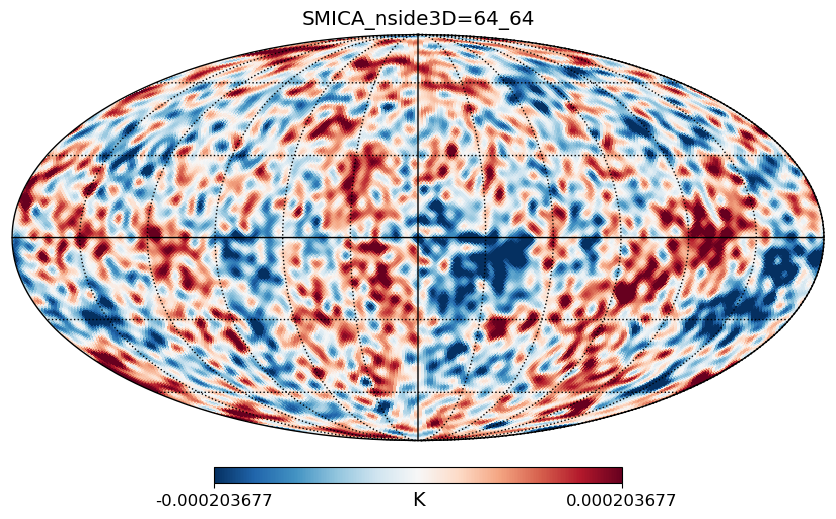

8034 8034 (8034, 49156)


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

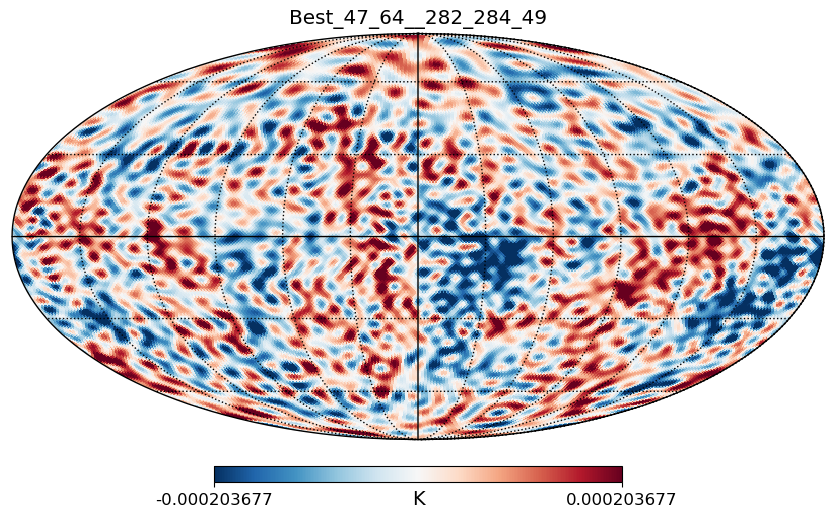

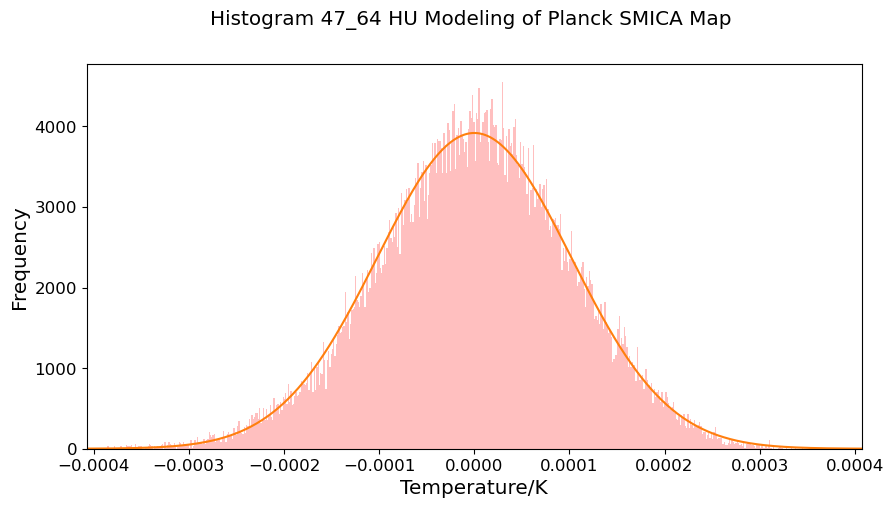

4.93231069 4.97130803 0.85524497 -2.662771131403202 Best_47_64__282_284_49
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 131
4.93231069 4.97130803 0.85524497 5.016630873892494e-09 Best_47_64__282_284_49


In [5]:
if Color.EVALUATE_DF_AT_POSITION in todo:
    x0 = [4.93231069, 4.97130803, 0.85524497] # interrupted optimized value 03/27/2024
    (lk, ll, lm) = x0
    print("evaluated at {}".format(x0))
    # Create karray
    karray = list(np.arange(2,48))
    karray = np.array(sorted(list(set(karray)))).astype(int)

    nside3D = 64
    bandwidth = 64
    # kmax=200
    # karray += sorted(list(set([int(k) for k in np.geomspace(49,kmax,20)])))
    karray = np.array(sorted(list(set(karray)))).astype(int)
    print(len(karray))
    kmax = max(karray)
    #################################
    if myHyper is None:
        mypath="./PG_data"
        myHyper = HYPER(nside3D, sigma_smica, planck_IQU_SMICA, karray, mypath,
                        lk, ll, lm, loadpriorG=True, savePG=True, bandwidth=bandwidth, longG=False)
    #################################################################
    results, newmap0, err = myHyper.project4D3d_0(karray)
    filename = "./img1/SingleBest_{}_{}__{}_{}_{}.png".format(kmax, nside3D, chg2ang(lk),
                                                              chg2ang(ll), chg2ang(lm))
    title = "Best_{}_{}__{}_{}_{}".format(kmax, nside3D, chg2ang(lk),
                                          chg2ang(ll), chg2ang(lm))

    myHyper.plotNewMap(newmap0, err, filename=filename, title=title, plotme=True, save=True)
    myHyper.plotHistogram(newmap0.squeeze(), nside3D, kmax, plotme=True)
    print(lk, ll, lm, err, title)
    df = pd.DataFrame(np.concatenate([results, myHyper.df[:, 0:4]], axis=1),
                      columns=["coeff", "k", "l", "m", "std"])
    filename = "./PG_data/spectrum_{}_{}__{}_{}_{}".format(kmax, nside3D, chg2ang(lk), chg2ang(ll), chg2ang(lm))
    df.to_pickle(filename)
    #################################################################
    np.save("./PG_data/resultsBest_{}_{}.npy".format(kmax, nside3D), results, allow_pickle=True)
    np.save("./img1/SMICA_LR.npy", myHyper.SMICA_LR)
    #################################################################
    #################################################################
    x01 = np.array([0.00140589, 0.43367364])
    x00 = minimize(newerr, x01, args=(myHyper.SMICA_LR, newmap0),
                   method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    err = x00.fun
    xx0 = x00.x
    newmap, diffmap = myHyper.optimizeNewMap(newmap0, myHyper.SMICA_LR,xx0,
                                             nside3D=nside3D, bandwidth=bandwidth, nosigma=False)
    
    #################################################################
    #################################################################
    #################################################################
    np.save("./img1/newmap.npy", newmap)
    np.save("./img1/diffmap.npy", diffmap)
    ###############################################################
    ###############################################################
#     myHyper.plot_Single_CL_From_Image(diffmap, nside3D, xmax=xmax)
#     myHyper.plot_Single_CL_From_Image(newmap, nside3D, xmax=xmax)
    ###############################################################
    ###############################################################
    print(lk, ll, lm, err, title)
    df = pd.DataFrame(np.concatenate([results, myHyper.df[:, 0:4]], axis=1),
                      columns=["coeff", "k", "l", "m", "std"])
    filename = "./PG_data/spectrum_{}_{}__{}_{}_{}".format(kmax, nside3D, chg2ang(lk), chg2ang(ll), chg2ang(lm))
    df.to_pickle(filename)
    #################################################################
    np.save("./PG_data/resultsBest_{}_{}.png".format(kmax, nside3D), results, allow_pickle=True)
    np.save("./img1/SMICA_LR.png", myHyper.SMICA_LR)
    #################################################################
    #################################################################

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

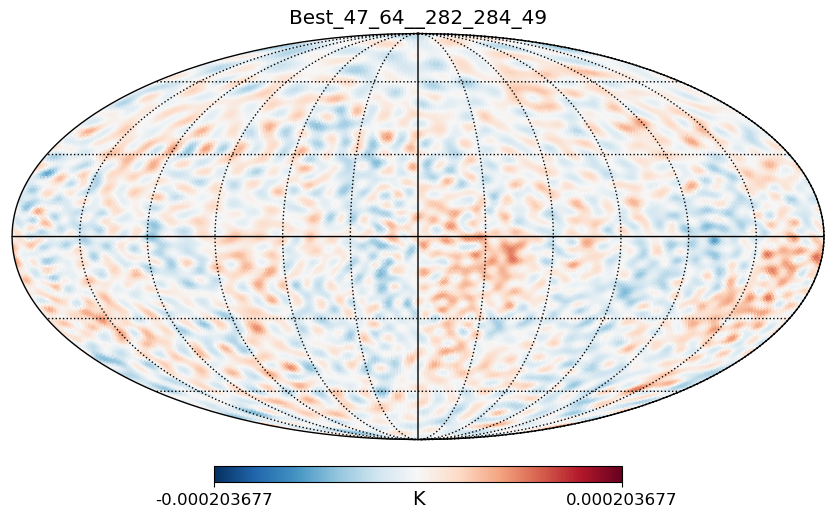

In [7]:
myHyper.plotNewMap(newmap-newmap0, err, filename=filename, title=title, plotme=True, save=False)

In [8]:
if Color.MINIMIZEPOSITION in todo:
    # Best Position = [(2.0943951023931953, 4.886921905584122, 4.886921905584122, -0.9543073989083581)]
    # x0= x00[-1:][0][0:3]
    # x0 = (2.0943951023931953, 4.886921905584122, 4.886921905584122)
    # x0 = [2.11999902, 4.84227338, 4.95303838]  # ksi, theta, phi = [121.47, 277.44, 283.79]
    # x0 = [2.0943951023931953, 5.235987755982988, 4.1887902047863905] # -0.9512365749096219 June 09
    # x0 = [2.13302707, 5.08554078, 4.34175881]  # -0.958704 [122.21, 291.38, 241.71] June9 Minimized
    # x0 = [4.92463563, 4.95336686, 0.8165214728204138]
    # x0 = [4.82349567, 4.88348719, 0.84566045] #- 3.3740886193323982  696721
    x0 = [4.82349567, 4.88348719, 0.84566045] #-3.442960596169308 9876
    nside3D = 64
    bandwidth = 64
    (lambda_k, lambda_l, lambda_m) = x0
    # Create karray
    karray = list(np.arange(2, 30))
    print(len(karray))
    kmax = max(karray)
    #################################
    if myHyper is None:
        myHyper = HYPER(nside3D, sigma_smica, planck_IQU_SMICA, karray,
                        lambda_k, lambda_l, lambda_m, loadpriorG=False, savePG=False, bandwidth=bandwidth)
    else:
        myHyper.loadpriorG = False
        myHyper.savePG = False
    #################################
    print(x0)
    x0 = minimize(myHyper.calcError, x0, args=(karray), method='nelder-mead',
                  options={'xatol': 1e-4, 'disp': True})
    np.save("./img1/x0_{}_{}.npy".format(kmax, nside3D), x0.x, allow_pickle=True)
    x0 = x0.x
    (lk, ll, lm) = x0
    print("minimized at {}".format(x0))
    filename = "./img1/Best_{}_{}__{}_{}_{}.png".format(kmax, nside3D, chg2ang(lk), chg2ang(ll), chg2ang(lm))
    title = "Best_{}_{}__{}_{}_{}".format(kmax, nside3D, chg2ang(lk), chg2ang(ll), chg2ang(lm))
    myHyper.change_HSH_center(lk, ll, lm, karray, nside3D, loadpriorG=False, doit=True, savePG=True)
    results, newmap, err = myHyper.project4D3d_0(karray)
    np.save("./img1/results_{}_{}.npy".format(kmax, nside3D), results, allow_pickle=True)
#################################################################


In [9]:
if Color.OPTIMIZE_SPECTRUM in todo:
    (lk, ll, lm) = x0
    # Create karray
    karray = list(np.arange(20, 222, 20))
    karray = np.array(sorted(list(set(karray)))).astype(int)
    print(len(karray))
    kmax = max(karray)
    nside3D = 128
    bandwidth = 1024
    myHyper = None
    myHyper = HYPER(nside3D, sigma_smica, planck_IQU_SMICA, karray,
                    lk, ll, lm, loadpriorG=True, savePG=True, bandwidth=bandwidth, longG=True)
    myHyper.SMICA_LR = np.load("./img1/diffmap.npy").T
    myHyper.plotNewMap(myHyper.SMICA_LR, 0, filename=None, title="DiffMap", plotme=True, save=False, nosigma=False)
    results, newmap, err, packedresults = myHyper.project4D3d_0(karray)
    # #################################
    myHyper.plot_Single_CL_From_Image(newmap, nside3D, xmax=50,log=True)
    myHyper.plot_Single_CL_From_Image(diffmap, nside3D, xmax=300)
    myHyper.plot_CL_From_Image(newmap, nside3D, planck_theory_cl, xmax=300, ymax=0)

    newnewmap = myHyper.SMICA_LR.squeeze() - xx0[1] * newmap.squeeze() + xx0[0]

    myHyper.plot_CL_From_Image(diffmap, nside3D, planck_theory_cl, xmax=300, ymax=0.1)

    myHyper.plot_CL_From_Image(myHyper.SMICA_LR.squeeze(), nside3D, planck_theory_cl, xmax=3000, ymax=1)
    df = pd.DataFrame(np.concatenate([results, myHyper.df[:, 0:4]], axis=1),
                      columns=["coeff", "k", "l", "m", "std"])
    filename = "./PG_data/spectrumOptimum_{}_{}__{}_{}_{}".format(kmax, nside3D, chg2ang(lk), chg2ang(ll),
                                                                  chg2ang(lm))
    df.to_pickle(filename)

    # subtract from SMICA the background
    SMICA_LR_NO_BG = myHyper.SMICA_LR.squeeze() - diffmap.squeeze()
    myHyper.plot_ONLY_CL_From_Image(newmap, nside3D, SMICA_LR_NO_BG, nsidesmica=nside3D, xmax=200)

    df["CL"] = df["coeff"] ** 2
    df["abscoeff"] = df.coeff.abs()

    fcolors = df.coeff.values
    (mu, sigma) = norm.fit(fcolors)
    n, bins, patch = plt.hist(fcolors, 600, density=1, facecolor="r", alpha=0.25)
    y = norm.pdf(bins, mu, sigma)
    plt.plot(bins, y)
    plt.xlim(mu - 4 * sigma, mu + 4 * sigma)
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    plt.ylim(0, 0.04)
    plt.title("Amplitude Histogram \n HU Modeling of Planck SMICA Map")
    plt.savefig("./PG_data/AmplitudeHistogram_{}_{}.png", dpi=300)
    plt.show()

    numberofmodes = df.groupby(['k'])["abscoeff"].count()
    meanAmplitude = df.groupby(['k'])["abscoeff"].mean()
    meanEnergy = meanAmplitude ** 2 * meanAmplitude.index * numberofmodes
    stdd = df.groupby(['k'])["abscoeff"].std()
    one = np.ones(stdd.shape)
    valueOfK = stdd.index.values

    # calculation of Predicted Amplitudes
    predictedAmp = 75 / np.sqrt(valueOfK)
    # low pass filtering
    predictedAmp = np.exp(-0.01 * (valueOfK - 2)) * predictedAmp
    # Frequency dependent freezing phase accounting
    delta = 0.01
    predictedAmp = sinxx(valueOfK * delta) * predictedAmp
    plt.plot(numberofmodes, predictedAmp)
    plt.scatter(numberofmodes, meanAmplitude)
    plt.title("Predicted and Observed Mean Amplitudes \n under Energy Equipartition per mode k")
    plt.xlabel("Accessible Modes for given k")
    plt.ylabel("Hyperspherical Mode Amplitude per k")
    plt.ylim(0, 25)
    plt.xlim(0, 250)
    plt.savefig("./PG_data/PredicedtAmp.png", dpi=300)
    plt.show()

    plt.plot(numberofmodes, meanEnergy)
    plt.title("Mean Energy per k")
    plt.xlabel("Accessible Modes for given k")
    plt.ylabel("Mean Energy per k \n arbitrary units")
    plt.xlim(0, 250)
    plt.ylim(0, 4.5E5)
    plt.savefig("./PG_data/MeanEnergy.png", dpi=300)
    plt.show()

    plt.scatter(numberofmodes, meanAmplitude)
    plt.title("Mean Amplitude per k")
    plt.xlabel("Accessible Modes for given k")
    plt.ylabel("Mean Amplitude per k")
    plt.ylim(0, 22.5)
    plt.xlim(0, 250)
    plt.savefig("./PG_data/MeanAmp.png", dpi=300)
    plt.show()

    plt.scatter(numberofmodes, stdd)
    plt.title("STD")
    plt.xlabel("Accessible Modes for given k")
    plt.ylabel("STD")
    plt.xlim(0, 250)
    plt.savefig("./PG_data/STD.png", dpi=300)
    plt.show()

    plt.plot(numberofmodes, meanAmplitude / stdd)
    plt.plot(numberofmodes, np.mean((meanAmplitude / stdd)[3:]) * one)
    plt.title("MeanAmplitude/std")
    plt.xlabel("Accessible Modes for given k")
    plt.ylabel("MeanAmplitude/std")
    plt.xlim(0, 250)
    plt.ylim(0, 2)
    plt.savefig("./PG_data/PredicedtAmpPerSTD.png", dpi=300)
    plt.show()
    ################################################################
    ################################################################
    ################################################################
    ################################################################
    ################################################################
    ################################################################
    #################################################################


In [10]:
if Color.FINDBESTFORKRANGE in todo:
    # myHyper.phi, myHyper.theta, myHyper.ksi = hp.pix2vec(nside=nside3D, ipix=np.arange(hp.nside2npix(nside=nside3D)))
    # myHyper.theta, myHyper.phi = hp.pix2ang(nside=nside3D,
    #                                                      ipix=np.arange(hp.nside2npix(nside=nside3D)))
    # myHyper.costheta = np.cos(myHyper.theta)
    # k = 9
    # l = 3
    # for m in np.arange(-l+1,l):
    #     pp = np.array([legendre(l, x) for x in myHyper.costheta])
    #     myHyper.plot_aitoff_df(l,m,myHyper.phi, pp=pp)
    #
    # x0=np.load("./img1/x0_{}_{}.npy".format(kmax, nside3D), allow_pickle=True)
    # x00 = np.load("./img1/x00_{}_{}.npy".format(kmax, nside3D), allow_pickle=True)
    # x0 = np.load("./img1/results_{}_{}.npy".format(kmax, nside3D), allow_pickle=True)
    # x0 = [5.45066325E+00, 1.36266581E+00, -2.65625000E-04]
    (lk, ll, lm) = x0
    myHyper.change_SMICA_resolution(nside3D, myHyper.sigma_smica, bandwidth=bandwidth)
    olderr = 1110.0

    for kk in [x for x in karray if x > 10]:
        print(kk)
        kkarray = [x for x in karray if x <= kk + 1]
        kmax = np.max(kkarray)
        results, newmap, err, packedresults = myHyper.project4D3d_0(kkarray)
        print(lk, ll, lm, err, "intermediate result")
        if err < olderr:
            olderr = err
            filename = "./img1/Best_{}_{}__{}_{}_{}_{}.png".format(kmax, nside3D, np.round(lk, 1),
                                                                   np.round(ll, 1), np.round(lm, 1),
                                                                   np.round(err * 1, 4))
            title = "Best_{}_{}__{}_{}_{}_{}".format(kmax, nside3D, np.round(lk, 1),
                                                     np.round(ll, 1), np.round(lm, 1),
                                                     np.round(err * 1, 4))
            myHyper.plotNewMap(newmap, err, filename=filename, title=title, plotme=True, save=True)
            print(lk, ll, lm, err, title)
            filenameResults = "./PG_data/Results_{}_{}__{}_{}_{}_{}.npy".format(kmax, nside3D, np.round(lk, 1),
                                                                                np.round(ll, 1),
                                                                                np.round(lm, 1),
                                                                                np.round(err * 1, 4))
            np.save(filenameResults, packedresults)
            np.save("./PG_data/resultsBest_{}_{}.npy".format(kmax, nside3D), results, allow_pickle=True)
            myHyper.plotHistogram(newmap.squeeze(), nside3D, kmax, plotme=True)
            myHyper.plotNewMap(newmap, err, filename=filename, title=title, plotme=True, save=False)
    dl_SMICA, dl_SMICA_HU, ell = myHyper.plot_ONLY_CL_From_Image(newmap.squeeze(), bandwidth, xmax=10 * kmax)


In [11]:
if Color.CREATE_GAUSSIAN_BACKGROUND in todo:
    nside3D = 128  # 128
    bandwidth = 3000
    filename = "./img1/3DGaussianNoise_{}_{}.png".format(kmax, nside3D)
    title = "3DGaussianNoise_{}_{}".format(kmax, nside3D)
    (lambda_k, lambda_l, lambda_m) = x0
    # Create karray
    karray = list(np.arange(2, 48))
    # kmax=1
    # karray += sorted(list(set([int(k) for k in np.geomspace(11,kmax,30)])))
    print(len(karray))
    kmax = max(karray)
    #################################
    myHyper = HYPER(nside3D, sigma_smica, planck_IQU_SMICA, karray,
                    lambda_k, lambda_l, lambda_m, loadpriorG=True, savePG=True)
    #################################################################
    delta = 0.001
    lmax = 1000
    llist = sorted(list(set([int(k) for k in np.geomspace(1, lmax + 1, 100)])))
    wavefunction = myHyper.createGaussianBackground(x0, nside3D, delta, karray=llist)
    wavefunction = myHyper.normalizeFColors(wavefunction, myHyper.sigma_smica).squeeze()
    myHyper.plotNewMap(wavefunction, 0, filename=filename, title=title, plotme=True, save=True)
    myHyper.plot_CL_From_Image(wavefunction, nside3D, planck_theory_cl, xmax=2 * lmax, ymax=0.01)
    myHyper.plot_ONLY_CL_From_Image(wavefunction, nside3D, myHyper.SMICA, nsidesmica=1024, xmax=2 * lmax)
    np.save("./PG_data/3DGaussianNoise_{}_{}.npy".format(kmax, nside3D), wavefunction, allow_pickle=True)
###############################################################
